# Signet Supply Model

## Library

In [1]:
import pypyodbc as podbc
import pandas as pd
from pandas import DataFrame
import datetime
from datetime import date
import matplotlib.pyplot as plt
# import statsmodels.api as sm
import plotly.express as px

import optuna
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns

## Load Data

In [ ]:
# # NOTE: Signet Supply Report
# #      Signet Utilization Report

# # Load utilization data
# df_Utilization= pd.read_excel(r"Signet_utilization_score.xlsx", sheet_name="Utilization Detail")

# # Load supply data
# df_Supplyorder= pd.read_excel(r"Signet_supply order.xlsx", sheet_name="Supply")

In [175]:
# NOTE: Signet Supply Report
#      Signet Utilization Report

# Load utilization data
df_Utilization= pd.read_excel(r"Signet_Summary.xlsx", sheet_name="Report 9", header = 1)
df_Utilization = df_Utilization.drop('Unnamed: 0', axis = 1)

# Load supply data
# df_Supplyorder= pd.read_excel(r"Signet_supply order.xlsx", sheet_name="Supply")

## Supply

### Data Cleaning and Feature Engineering

In [ ]:
df_Supplyorder['Brand'] = df_Supplyorder['Brand'].str.strip()
df_Supplyorder['Model (Attr)'] = df_Supplyorder['Model (Attr)'].str.strip()

# Identifying the numerical and categorical columns in the supply data
supply_numerical_cols = df_Supplyorder.select_dtypes(include='number').columns.tolist()
supply_categorical_cols = df_Supplyorder.columns[~df_Supplyorder.columns.isin(supply_numerical_cols)].to_list()

df_Supplyorder['month'] = pd.to_datetime(df_Supplyorder['Created On']).dt.month
df_Supplyorder['day'] = pd.to_datetime(df_Supplyorder['Created On']).dt.day
df_Supplyorder['day_num'] = pd.to_datetime(df_Supplyorder['Created On']).dt.day_of_week

In [46]:
# grouping the supply data
df_supply_group = df_Supplyorder.groupby(supply_categorical_cols).sum().reset_index()

df_supply_group_special = df_Supplyorder[['Created On', 'Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'month', 'day', 'day_num', 'Total Read', 'ZYIELD', 'Line Count']].groupby(
    ['Created On', 'Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'month', 'day', 'day_num',]
).sum().reset_index()

In [47]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_supply_group_special['brand_encoded'] = le.fit_transform(df_supply_group_special['Brand'])
df_supply_group_special['color_encoded'] = le.fit_transform(df_supply_group_special['Color'])
df_supply_group_special['model_encoded'] = le.fit_transform(df_supply_group_special['Model (Attr)'])
df_supply_group_special['ship_to_name_encoded'] = le.fit_transform(df_supply_group_special['Ship To Name'])

In [48]:
supply_group_features = ['month', 'day',
       'day_num', 'Total Read', 'ZYIELD', 'brand_encoded',
       'color_encoded', 'model_encoded', 
       'ship_to_name_encoded'
       ]

#### Supply Group Model

In [49]:
# Supply group model

target = 'Line Count'

# Use only the training portion for tuning
train_data = df_supply_group_special[(df_supply_group_special['Created On'] < '2025-01-01') ]
test = df_supply_group_special[df_supply_group_special['Created On'] >= '2025-01-01']

# TimeSeriesSplit setup
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'min_sum_hessian_in_leaf': 1e-3,
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'force_row_wise': True
    }

    rmses = []

    for train_idx, val_idx in tscv.split(train_data):
        train_fold = train_data.iloc[train_idx]
        val_fold = train_data.iloc[val_idx]

        lgb_train = lgb.Dataset(train_fold[supply_group_features], label=train_fold[target], categorical_feature=['color_encoded', 'brand_encoded', 'model_encoded', 'ship_to_name_encoded'])
        lgb_val = lgb.Dataset(val_fold[supply_group_features], label=val_fold[target], reference=lgb_train)

        model = lgb.train(params, lgb_train, valid_sets=[lgb_val], )
        preds = np.clip(model.predict(val_fold[supply_group_features]), 0, None)
        rmse = np.sqrt(mean_squared_error(val_fold[target], preds))
        rmses.append(rmse)

    return np.mean(rmses)

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get best parameters
best_params = study.best_params
best_params.update({'objective': 'regression', 'metric': 'mae', 'verbosity': -1})

# Train on full training set
train_final = df_supply_group_special[df_supply_group_special['Created On'] < '2025-01-01']
test_final = df_supply_group_special[df_supply_group_special['Created On'] >= '2025-01-01']

lgb_train = lgb.Dataset(train_final[supply_group_features], label=train_final[target], categorical_feature=['color_encoded', 'brand_encoded', 'model_encoded', 'ship_to_name_encoded'])
lgb_test = lgb.Dataset(test_final[supply_group_features], label=test_final[target], reference=lgb_train)

model = lgb.train(best_params, lgb_train, valid_sets=[lgb_test], )

# Evaluate
preds = np.clip(model.predict(test_final[supply_group_features]), 0, None)
mae = mean_absolute_error(test_final[target], preds)
rmse = np.sqrt(mean_squared_error(test_final[target], preds))
r2 = r2_score(test_final[target], preds)

print("Best Parameters:", best_params)
print(f"Final Model MAE: {mae:.4f}")
print(f"Final Model RMSE: {rmse:.4f}")
print(f"Final Model R^2: {r2:.4f}")

[I 2025-07-29 13:52:47,334] A new study created in memory with name: no-name-d47338ed-9ebb-4737-8f8f-7bca7b8ce576
[I 2025-07-29 13:52:49,530] Trial 0 finished with value: 0.5417564916051982 and parameters: {'learning_rate': 0.04296637886559061, 'num_leaves': 49, 'max_depth': 5, 'min_data_in_leaf': 20, 'feature_fraction': 0.8948120888215659, 'bagging_fraction': 0.9087632782827403, 'lambda_l1': 1.8148990162603507, 'lambda_l2': 3.076468374998758}. Best is trial 0 with value: 0.5417564916051982.
[I 2025-07-29 13:52:51,576] Trial 1 finished with value: 0.5464997825734934 and parameters: {'learning_rate': 0.08734569541763687, 'num_leaves': 20, 'max_depth': 4, 'min_data_in_leaf': 29, 'feature_fraction': 0.8182875255083816, 'bagging_fraction': 0.6010576852308607, 'lambda_l1': 2.848890455260613, 'lambda_l2': 1.9704509870211524}. Best is trial 0 with value: 0.5417564916051982.
[I 2025-07-29 13:52:57,150] Trial 2 finished with value: 0.5301388220106635 and parameters: {'learning_rate': 0.09137761

Best Parameters: {'learning_rate': 0.018740345337200457, 'num_leaves': 57, 'max_depth': 9, 'min_data_in_leaf': 29, 'feature_fraction': 0.6976437307532328, 'bagging_fraction': 0.7917161621958948, 'lambda_l1': 4.308193475027047, 'lambda_l2': 2.3199018428663876, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Final Model MAE: 0.0542
Final Model RMSE: 0.2412
Final Model R^2: 0.8583


Best Parameters: {'learning_rate': 0.018740345337200457, 'num_leaves': 57, 'max_depth': 9, 'min_data_in_leaf': 29, 'feature_fraction': 0.6976437307532328, 'bagging_fraction': 0.7917161621958948, 'lambda_l1': 4.308193475027047, 'lambda_l2': 2.3199018428663876, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Final Model MAE: 0.0542
Final Model RMSE: 0.2412
Final Model R^2: 0.8583

##### Supply Group Feature Importance

In [50]:
# Extract feature importances and feature names
importances = model.feature_importance()
feature_names = model.feature_name()

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot with Plotly
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h', template = 'plotly_dark', 
             title='Feature Importance (LightGBM)',
             labels={'Importance': 'Importance Score', 'Feature': 'Feature'},
            #  height=800
             )

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

##### Supply Group Actual vs Predicted

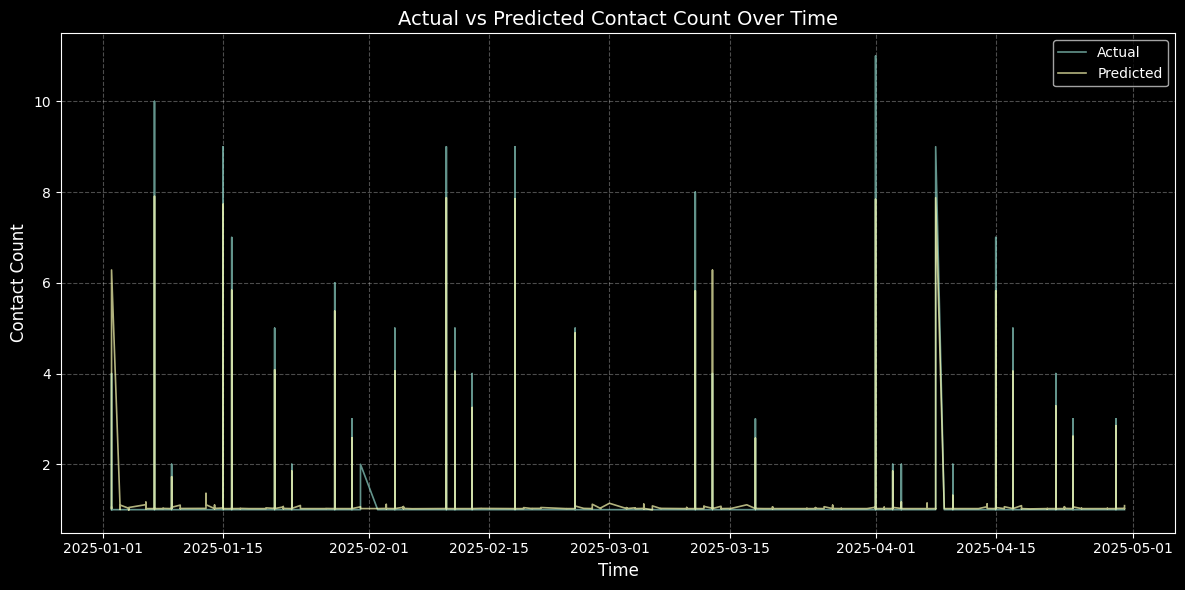

In [51]:
# Plot actual vs predicted
plot_df = test[['Created On', 'Line Count']].copy()
plot_df['Predicted'] = preds
plot_df = plot_df.rename(columns={'Line Count': 'Actual'})

plot_df = plot_df.sort_values('Created On')

plot_df_melted = plot_df.melt(id_vars='Created On', value_vars=['Actual', 'Predicted'],
                              var_name='Type', value_name='Line Count')

import matplotlib.pyplot as plt

# Enable dark mode
plt.style.use('dark_background')

# Create the plot
plt.figure(figsize=(12, 6), dpi=100)  # High resolution
plt.plot(plot_df['Created On'], plot_df['Actual'], label='Actual', alpha=0.7, linewidth=1.2)
plt.plot(plot_df['Created On'], plot_df['Predicted'], label='Predicted', alpha=0.7, linewidth=1.2)

# Customize labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Contact Count', fontsize=12)
plt.title('Actual vs Predicted Contact Count Over Time', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

##### Supply Group Correlation Matrix Heatmap

In [52]:
# Select the relevant numeric columns
columns = ['month', 'day', 'day_num', 'Total Read', 'ZYIELD', 
           'brand_encoded', 'color_encoded', 'model_encoded', 
           'ship_to_name_encoded', 'Line Count']

# Filter the DataFrame
dfsupply = df_supply_group_special[columns]

# Compute the correlation matrix
correlation_matrix = dfsupply.corr()

# Round the correlation values to 2 decimal places
correlation_matrix = correlation_matrix.round(2)


# Create the heatmap using Plotly Express
fig = px.imshow(correlation_matrix,
                text_auto=True,
                width=800, height=800,
                color_continuous_scale='RdBu_r',
                aspect='auto',
                zmin=-1, zmax=1,
                title='Correlation Matrix Heatmap', template='plotly_dark')

fig.show()


In [53]:
correlation_matrix['Line Count'].sort_values(ascending=False).reset_index().rename(columns={'index':'Feature'})

,Feature,Line Count
0,Line Count,1.00
1,Total Read,0.40
2,color_encoded,0.19
3,ZYIELD,0.09
4,day,0.02
5,month,-0.01
6,day_num,-0.02
7,model_encoded,-0.06
8,ship_to_name_encoded,-0.13
9,brand_encoded,-0.14


In [37]:
import joblib

# Save the model
joblib.dump(model, 'supply_model_r2_86.pkl')

['supply_model_r2_86.pkl']

## Utilization

<span style = "color>:gold"> Get `days since last order` data

### Feature Engineering

In [ ]:
# # Clean categorical data
# df_Utilization['Brand'] = df_Utilization['Brand'].str.strip()
# df_Utilization['Model (Attr)'] = df_Utilization['Model (Attr)'].str.strip()

# # Identifying the numerical and categorical columns in the supply data
# util_numerical_cols = df_Utilization.select_dtypes(include='number').columns.tolist()
# util_categorical_cols = df_Utilization.columns[~df_Utilization.columns.isin(util_numerical_cols)].to_list()

# # create month and day features
# df_Utilization['month'] = pd.to_datetime(df_Utilization['Created On']).dt.month
# df_Utilization['day'] = pd.to_datetime(df_Utilization['Created On']).dt.day
# df_Utilization['day_num'] = pd.to_datetime(df_Utilization['Created On']).dt.day_of_week

# # create utilization feature
# df_Utilization['Utilization Score'] = df_Utilization['Total AMV']/(df_Utilization['ZYIELD']/2)

# # grouping the util data
# df_util_group = df_Utilization.groupby(util_categorical_cols).sum().reset_index()

# df_util_group_special = df_Utilization[['Created On', 'Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'month', 'day', 'day_num', 'Total Read', 'ZYIELD', 'Line Count','Utilization Score', 'Total AMV']].groupby(
#     ['Created On', 'Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'month', 'day', 'day_num',]
# ).sum().reset_index()

# # encode categorical features
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df_util_group_special['brand_encoded'] = le.fit_transform(df_util_group_special['Brand'])
# df_util_group_special['color_encoded'] = le.fit_transform(df_util_group_special['Color'])
# df_util_group_special['model_encoded'] = le.fit_transform(df_util_group_special['Model (Attr)'])
# df_util_group_special['ship_to_name_encoded'] = le.fit_transform(df_util_group_special['Ship To Name'])

### Training Features

In [ ]:
# # isolate training features
# util_train_features = ['month', 'day',
#        'day_num', 'Total Read', 'ZYIELD', 'brand_encoded',
#        'color_encoded', 'model_encoded', 
#        'ship_to_name_encoded', 'Utilization Score', 'Total AMV'
#        ]

### Split Train and Test and Identify Target Feature

<span style = "color:gold">Issue with this is that it is not accounting for zeros. When densified, the ammount of zeros overwhelm the model. However, without zeros, the forcast does not know how to predict days without values. 

In [178]:
# Clean categorical data
df_Utilization['Brand'] = df_Utilization['Brand'].str.strip()
df_Utilization['Model (Attr)'] = df_Utilization['Model (Attr)'].str.strip()

# create month and day features
df_Utilization['month'] = pd.to_datetime(df_Utilization['Created On']).dt.month
df_Utilization['year'] = pd.to_datetime(df_Utilization['Created On']).dt.year
df_Utilization['day'] = pd.to_datetime(df_Utilization['Created On']).dt.day
df_Utilization['day_num'] = pd.to_datetime(df_Utilization['Created On']).dt.day_of_week

# create utilization feature
df_Utilization['Utilization Score'] = df_Utilization['Total AMV'] / (df_Utilization['ZYIELD'] / 2)

# group the utilization data by a subset of columns
df_util_group_special = df_Utilization[['Created On', 'Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'year',
                                        'month', 'day', 'day_num', 'Total Read', 'ZYIELD',
                                        'Line Count', 'Utilization Score', 'Total AMV']].groupby(
    ['Created On', 'Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'year', 'month', 'day', 'day_num',]
).sum().reset_index()

# --- 2. Encode categorical features and store encoders (Refactored) ---
# Create a dictionary to hold the label encoders
encoders = {}
categorical_features_to_encode = ['Brand', 'Model (Attr)', 'Color', 'Ship To Name']

for feature in categorical_features_to_encode:
    le = LabelEncoder()
    df_util_group_special[f'{feature.replace(" ", "_").replace("(", "").replace(")", "").lower()}_encoded'] = le.fit_transform(df_util_group_special[feature])
    encoders[feature] = le # Store the fitted encoder

# isolate training features
util_train_features = [
    'year', 'month', 'day', 'day_num', 'Total Read', 'ZYIELD', 'Utilization Score', 'Total AMV',
    'brand_encoded', 'color_encoded', 'model_attr_encoded', 'ship_to_name_encoded'
]

In [ ]:
df_util_group_month = df_Utilization[['Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'year',
                                        'month', 'Total Read', 'ZYIELD',
                                        'Line Count', 'Utilization Score', 'Total AMV']].groupby(
    ['Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'year', 'month']
).sum().reset_index()

df_util_group_month['year_month'] = df_util_group_month['year'].astype(str) + '-' + df_util_group_month['month'].astype(str)

# --- 2. Encode categorical features and store encoders (Refactored) ---
# Create a dictionary to hold the label encoders
encoders = {}
categorical_features_to_encode = ['Brand', 'Model (Attr)', 'Color', 'Ship To Name']

for feature in categorical_features_to_encode:
    le = LabelEncoder()
    df_util_group_month[f'{feature.replace(" ", "_").replace("(", "").replace(")", "").lower()}_encoded'] = le.fit_transform(df_util_group_month[feature])
    encoders[feature] = le # Store the fitted encoder

# isolate training features
util_train_features = [
    'year', 'month', 'Total Read', 'ZYIELD', 'Utilization Score', 'Total AMV',
    'brand_encoded', 'color_encoded', 'model_attr_encoded', 'ship_to_name_encoded'
]

# Utilization model

target = 'Line Count'

# Use only the training portion for tuning
train_data = df_util_group_month[(df_util_group_month['year_month'] < '2025-01') ]
test = df_util_group_month[df_util_group_month['year_month'] >= '2025-01']

In [ ]:
# Utilization model

target = 'Line Count'

# Use only the training portion for tuning
train_data = df_util_group_special[(df_util_group_special['Created On'] < '2025-01-01') ]
test = df_util_group_special[df_util_group_special['Created On'] >= '2025-01-01']

### Build Model and Hyperparameter Tuning

In [208]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from optuna.integration import LightGBMPruningCallback
import warnings
from lightgbm import early_stopping, log_evaluation
import numpy as np

# Suppress the specific Optuna warning
warnings.filterwarnings("ignore", category=UserWarning)

# TimeSeriesSplit setup
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse', # 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'min_sum_hessian_in_leaf': 1e-3,
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'force_row_wise': True,
    }

    r2_scores = []
    
    # We will use the last fold for pruning, as it's the most recent data
    for i, (train_idx, val_idx) in enumerate(tscv.split(train_data)):
        train_fold = train_data.iloc[train_idx]
        val_fold = train_data.iloc[val_idx]

        lgb_train = lgb.Dataset(train_fold[util_train_features], label=train_fold[target])
        lgb_val = lgb.Dataset(val_fold[util_train_features], label=val_fold[target], reference=lgb_train, categorical_feature=['color_encoded', 'brand_encoded', 'model_attr_encoded', 'ship_to_name_encoded'])

        # Only pass the pruning callback to the last fold to avoid the warning
        callbacks = [early_stopping(stopping_rounds=100, verbose=False),
                     log_evaluation(period=0) # This will stop the verbose output
                     ]
        if i == tscv.get_n_splits() - 1:
            callbacks.append(LightGBMPruningCallback(trial, "rmse"))

        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            callbacks=callbacks,
            )
        

        preds = np.clip(model.predict(val_fold[util_train_features], num_iteration=model.best_iteration), 0, None)
        r2 = r2_score(val_fold[target], preds)
        r2_scores.append(r2)

    return -np.mean(r2_scores)
    #     rmse = np.sqrt(mean_squared_error(val_fold[target], preds))
    #     rmses.append(rmse)

    # return np.mean(rmses)

# Run optimization
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(objective, n_trials=50)

# Get best parameters
best_params = study.best_params
best_params.update({'objective': 'regression', 'metric': 'mae', 'verbosity': -1})

# # Train on full training set
# train_final = df_util_group_special[df_util_group_special['Created On'] < '2025-01-01']
# test_final = df_util_group_special[df_util_group_special['Created On'] >= '2025-01-01']

# Train on full training set
train_final = df_util_group_month[df_util_group_month['year_month'] < '2025-01']
test_final = df_util_group_month[df_util_group_month['year_month'] >= '2025-01']

lgb_train = lgb.Dataset(train_final[util_train_features], label=train_final[target])
lgb_test = lgb.Dataset(test_final[util_train_features], label=test_final[target], reference=lgb_train, categorical_feature=['color_encoded', 'brand_encoded', 'model_attr_encoded', 'ship_to_name_encoded'])

model = lgb.train(best_params, lgb_train, valid_sets=[lgb_test], )

# Evaluate
preds = np.clip(model.predict(test_final[util_train_features]), 0, None)
mae = mean_absolute_error(test_final[target], preds)
rmse = np.sqrt(mean_squared_error(test_final[target], preds))
r2 = r2_score(test_final[target], preds)

print("Best Parameters:", best_params)
print(f"Final Model MAE: {mae:.4f}")
print(f"Final Model RMSE: {rmse:.4f}")
print(f"Final Model R^2: {r2:.4f}")

[I 2025-08-06 22:05:05,235] A new study created in memory with name: no-name-0720ce94-f5b1-4a7f-a374-35cf0447c0d7
[I 2025-08-06 22:05:07,274] Trial 0 finished with value: -0.2562244965726214 and parameters: {'learning_rate': 0.03554921316296943, 'num_leaves': 46, 'max_depth': 10, 'min_data_in_leaf': 29, 'feature_fraction': 0.6913161307031704, 'bagging_fraction': 0.935195365681313, 'lambda_l1': 0.9787981078817709, 'lambda_l2': 0.1922906584555789}. Best is trial 0 with value: -0.2562244965726214.
[I 2025-08-06 22:05:08,816] Trial 1 finished with value: -0.3141672597256576 and parameters: {'learning_rate': 0.07706827574247761, 'num_leaves': 36, 'max_depth': 9, 'min_data_in_leaf': 17, 'feature_fraction': 0.9661217248118215, 'bagging_fraction': 0.783636541514881, 'lambda_l1': 3.685751435014664, 'lambda_l2': 4.251725649208531}. Best is trial 1 with value: -0.3141672597256576.
[I 2025-08-06 22:05:10,548] Trial 2 finished with value: -0.18486309669733228 and parameters: {'learning_rate': 0.018

Best Parameters: {'learning_rate': 0.0946628579559136, 'num_leaves': 50, 'max_depth': 9, 'min_data_in_leaf': 40, 'feature_fraction': 0.9222831235787626, 'bagging_fraction': 0.9721742565437432, 'lambda_l1': 3.1989196961685056, 'lambda_l2': 2.7155281205198305, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Final Model MAE: 0.0530
Final Model RMSE: 0.4229
Final Model R^2: 0.9507


Best Parameters: {'learning_rate': 0.014471751706276077, 'num_leaves': 48, 'max_depth': 5, 'min_data_in_leaf': 12, 'feature_fraction': 0.6374152229671644, 'bagging_fraction': 0.9289648476405755, 'lambda_l1': 0.27744527482706194, 'lambda_l2': 0.5473580520094363, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Final Model MAE: 0.0607
Final Model RMSE: 0.1517
Final Model R^2: 0.9440

Best Parameters: {'learning_rate': 0.062057525454152794, 'num_leaves': 39, 'max_depth': 8, 'min_data_in_leaf': 14, 'feature_fraction': 0.649343699507569, 'bagging_fraction': 0.9786031765968543, 'lambda_l1': 2.884396110827601, 'lambda_l2': 4.990429368824895, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Final Model MAE: 0.0228
Final Model RMSE: 0.1519
Final Model R^2: 0.9438

includes year - still not a great forecast

Best Parameters: {'learning_rate': 0.0993988179837413, 'num_leaves': 49, 'max_depth': 8, 'min_data_in_leaf': 12, 'feature_fraction': 0.6763667290063162, 'bagging_fraction': 0.8760457182145337, 'lambda_l1': 1.032811833951817, 'lambda_l2': 1.3608864679245676, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Final Model MAE: 0.0327
Final Model RMSE: 0.1818
Final Model R^2: 0.9195

from the monthly binned data

Best Parameters: {'learning_rate': 0.0946628579559136, 'num_leaves': 50, 'max_depth': 9, 'min_data_in_leaf': 40, 'feature_fraction': 0.9222831235787626, 'bagging_fraction': 0.9721742565437432, 'lambda_l1': 3.1989196961685056, 'lambda_l2': 2.7155281205198305, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1}
Final Model MAE: 0.0530
Final Model RMSE: 0.4229
Final Model R^2: 0.9507

### Import Saved Model

In [13]:
import joblib

model = joblib.load('util_model_r2_93v2.pkl')

# Train on full training set
train_final = df_util_group_special[df_util_group_special['Created On'] < '2025-01-01']
test_final = df_util_group_special[df_util_group_special['Created On'] >= '2025-01-01']

# Evaluate
preds = np.clip(model.predict(test_final[util_train_features]), 0, None)
mae = mean_absolute_error(test_final[target], preds)
rmse = np.sqrt(mean_squared_error(test_final[target], preds))
r2 = r2_score(test_final[target], preds)

# print("Best Parameters:", best_params)
print(f"Final Model MAE: {mae:.4f}")
print(f"Final Model RMSE: {rmse:.4f}")
print(f"Final Model R^2: {r2:.4f}")

Final Model MAE: 0.0614
Final Model RMSE: 0.1692
Final Model R^2: 0.9303


### Feature Importance

In [209]:
# Extract feature importances and feature names
importances = model.feature_importance()
feature_names = model.feature_name()

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot with Plotly
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h', template = 'plotly_dark', 
             title='Feature Importance (LightGBM)',
             labels={'Importance': 'Importance Score', 'Feature': 'Feature'},
            #  height=800
             )

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

### Actual vs Predicted

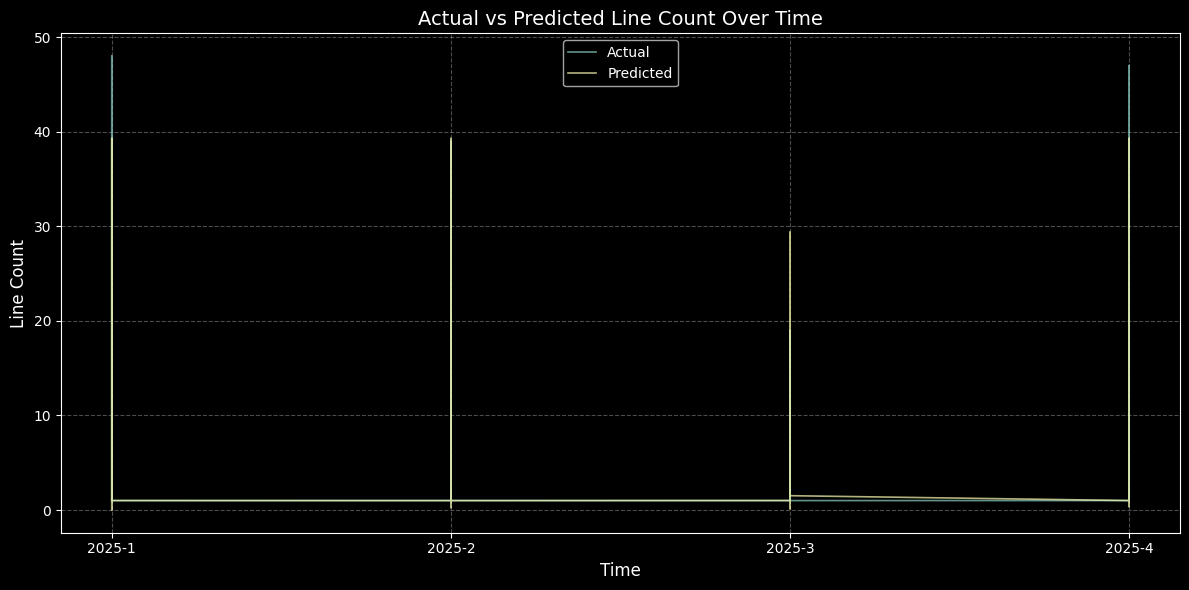

In [210]:
# Plot actual vs predicted

date_style = 'year_month' # 'Created On'

plot_df = test[[date_style, 'Line Count']].copy()
plot_df['Predicted'] = preds
plot_df = plot_df.rename(columns={'Line Count': 'Actual'})

plot_df = plot_df.sort_values(date_style)

plot_df_melted = plot_df.melt(id_vars=date_style, value_vars=['Actual', 'Predicted'],
                              var_name='Type', value_name='Line Count')

import matplotlib.pyplot as plt

# Enable dark mode
plt.style.use('dark_background')

# Create the plot
plt.figure(figsize=(12, 6), dpi=100)  # High resolution
plt.plot(plot_df[date_style], plot_df['Actual'], label='Actual', alpha=0.7, linewidth=1.2)
plt.plot(plot_df[date_style], plot_df['Predicted'], label='Predicted', alpha=0.7, linewidth=1.2)

# Customize labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Line Count', fontsize=12)
plt.title('Actual vs Predicted Line Count Over Time', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Correlation Matrix

In [211]:
# Select the relevant numeric columns
# columns = ['year', 'month', 'day', 'day_num', 'Total Read', 'ZYIELD', 
#            'brand_encoded', 'color_encoded', 'model_attr_encoded', 
#            'ship_to_name_encoded', 'Utilization Score', 'Total AMV', 'Line Count']

columns = ['year', 'month', 'Total Read', 'ZYIELD', 
           'brand_encoded', 'color_encoded', 'model_attr_encoded', 
           'ship_to_name_encoded', 'Utilization Score', 'Total AMV', 'Line Count']

# Filter the DataFrame
# dfutil = df_util_group_special[columns]

# using month
dfutil = df_util_group_month[columns]

# Compute the correlation matrix
correlation_matrix = dfutil.corr()

# Round the correlation values to 2 decimal places
correlation_matrix = correlation_matrix.round(2)


# Create the heatmap using Plotly Express
fig = px.imshow(correlation_matrix,
                text_auto=True,
                width=800, height=800,
                color_continuous_scale='RdBu_r',
                aspect='auto',
                zmin=-1, zmax=1,
                title='Correlation Matrix Heatmap', template='plotly_dark')

fig.show()


In [212]:
correlation_matrix['Line Count'].sort_values(ascending=False).reset_index().rename(columns={'index':'Feature'})

,Feature,Line Count
0,Line Count,1.00
1,Total AMV,0.82
2,Utilization Score,0.74
3,Total Read,0.70
4,ZYIELD,0.53
5,color_encoded,0.14
6,month,-0.00
7,year,-0.04
8,model_attr_encoded,-0.04
9,ship_to_name_encoded,-0.09


### Save Model

In [ ]:
# import joblib

# # Save the model
# joblib.dump(model, 'util_month_model_r2_95.pkl')

['util_month_model_r2_95.pkl']

### Forcasting

Forecasting Monthly

In [218]:
# --- 5. The Forecasting Function ---
def forecast_line_count(model, historical_df, encoders, n_months=1):
    """
    Generates a forecast for Line Count for the next n_months for each unique
    combination of Brand, Model, Color, and Ship To Name.
    """
    # Use the last year_month from the historical data
    last_year_month = pd.to_datetime(historical_df['year_month']).max()
    
    # Generate future year_month periods, not days
    future_dates = pd.date_range(
        start=last_year_month + pd.DateOffset(months=1), 
        periods=n_months, 
        freq='MS' # Use 'MS' for month start frequency
    )
    
    # Create the future DataFrame with year_month and extract year and month
    future_df = pd.DataFrame({'year_month': future_dates.strftime('%Y-%m')})
    future_df['year'] = future_dates.year
    future_df['month'] = future_dates.month
    
    unique_combinations = historical_df[['Brand', 'Model (Attr)', 'Color', 'Ship To Name']].drop_duplicates()

    # Create the forecast grid by merging unique combinations with future dates
    future_df_expanded = pd.DataFrame()
    for _, row in unique_combinations.iterrows():
        temp_df = future_df.copy()
        for col in unique_combinations.columns:
            temp_df[col] = row[col]
        future_df_expanded = pd.concat([future_df_expanded, temp_df], ignore_index=True)

    # Use the last known values for the numerical features for forecasting
    last_values = historical_df.sort_values('year_month').groupby(
        ['Brand', 'Model (Attr)', 'Color', 'Ship To Name']
    ).tail(1).reset_index(drop=True)
    
    future_df_expanded = pd.merge(
        future_df_expanded,
        last_values[['Brand', 'Model (Attr)', 'Color', 'Ship To Name', 'Total Read', 'ZYIELD', 'Utilization Score', 'Total AMV']],
        on=['Brand', 'Model (Attr)', 'Color', 'Ship To Name'],
        how='left'
    )
    
    # Fill any NaN values that might arise from new combinations with 0
    for col in ['Total Read', 'ZYIELD', 'Utilization Score', 'Total AMV']:
        future_df_expanded[col] = future_df_expanded[col].fillna(0)

    for feature in categorical_features_to_encode:
        encoded_col_name = f'{feature.replace(" ", "_").replace("(", "").replace(")", "").lower()}_encoded'
        try:
            future_df_expanded[encoded_col_name] = encoders[feature].transform(future_df_expanded[feature])
        except ValueError:
            future_df_expanded[encoded_col_name] = -1

    future_features = future_df_expanded[util_train_features]
    forecast_preds = np.clip(model.predict(future_features), 0, None)
    future_df_expanded['Forecasted Line Count'] = forecast_preds
    
    return future_df_expanded[['year_month', 'Brand', 'Model (Attr)', 'Ship To Name', 'Color', 'Forecasted Line Count']]

In [219]:
# --- 6. Example Usage of the Forecasting Function ---
print("\n" + "="*30)
print("Generating 1-month forecast...")
print("="*30)
df_forecast = forecast_line_count(model, df_util_group_month, encoders, n_months=1)


Generating 1-month forecast...


In [228]:
df_forecast

,year_month,Brand,Model (Attr),Ship To Name,Color,Forecasted Line Count,forcasted_line_count_int
0,2025-05,03765 BANTER BY PIERCING PA,BRMFCL2750,03765 BANTER BY PIERCING PAGODA,K,1.000136,1
1,2025-05,BANTER BY PIERCING PAGODA,BRMFCL2750,BANTER BY PIERCING PAGODA 2454,K,1.005371,1
2,2025-05,BANTER BY PIERCING PAGODA,BRMFCL2750,BANTER BY PIERCING PAGODA 2511,K,1.004817,1
3,2025-05,BANTER BY PIERCING PAGODA,BRMFCL2750,BANTER BY PIERCING PAGODA 2549,K,1.001957,1
4,2025-05,BANTER BY PIERCING PAGODA,BRMFCL2750,BANTER BY PIERCING PAGODA 2621,K,1.005371,1
...,...,...,...,...,...,...,...
6533,2025-05,ZALES OUTLET,LXMX421,ZALES OUTLET 2864,K,1.131617,1
6534,2025-05,ZALES OUTLET,LXMX431,ZALES OUTLET 2810,K,1.077651,1
6535,2025-05,ZALES OUTLET,LXMX431,ZALES OUTLET 2810,Unknown,1.403505,1
6536,2025-05,ZALES REPAIR SHOP,BRHLL8360CDW,ZALES REPAIR SHOP 8600,Unknown,2.880587,2


In [226]:
df_forecast['forcasted_line_count_int'] = np.floor(df_forecast['Forecasted Line Count']).astype(int)

In [234]:
df_forecast[['Ship To Name', 'forcasted_line_count_int']].groupby('Ship To Name').sum().reset_index().sort_values('forcasted_line_count_int').to_csv('2025-05_month_forecast.csv')